# Классические методы

Данная часть основана на ноутбуке из курса [Natural Language Processing with Probabilistic Models](https://www.coursera.org/learn/probabilistic-models-in-nlp)



Вы каждый день используете функцию автокоррекции на своем мобильном телефоне и компьютере. В этом задании Вы реализуете аналогичную модель :)

<a name='0-1'></a>
### Edit Distance

Расстояние Левенштейна, или редакционное расстояние (англ.: edit distance), — метрика cходства между двумя строковыми последовательностями. Чем больше расстояние, тем более различны строки. Для двух одинаковых последовательностей расстояние равно нулю.

* Два слова находятся на расстоянии n друг от друга, если нужно совершить n изменений для превращения одного слова в другое.

Изменение может происходить следующим образом:

- Удаление буквы: ‘hat’ => ‘at, ha, ht’
- Замена буквы: ‘jat’ => ‘hat, rat, cat, mat, ...’
- Поменять две соседние буквы:  ‘eta’ => ‘eat, tea,...’
- Вставка буквы: ‘te’ => ‘the, ten, ate, ...’

Мы будем использовать данные замены, чтобы реализовать метод автокоррекции.


Чтобы реализовать автокорректор, нужно для каждого слова $w$ **уметь считать вероятность того, что оно корректное**:

$$P(c|w) = \frac{P(w|c)\times P(c)}{P(w)} \tag{1} $$


В уравнении (1) записана формула Байеса, где:

- $P(w)$ -- вероятность появления слова $w$.

- $P(c|w)$ -- вероятность того, что слово $w$ корректно.

- $P(w|c)$ -- вероятность слова $w$ при условии того, что оно корректно.

- $P(c)$ -- вероятность появления корректного слова

<a name='1'></a>
### Часть 1: Data Preprocessing

Как и в любой другой задаче машинного обучения, первое, что вам нужно сделать, - это обработать ваш набор данных. Мы будем строить автокорректор на основе текста Шекспира (файл 'shakespeare.txt')

Нужно прочитать файл, привести все к нижнему регистру, и получить список всех слов. В дальнейшем мы будем называть список всех слов из данного файла вокабуляром (vocabulary).

In [ ]:
import re
from collections import Counter
import numpy as np
import pandas as pd

In [ ]:
def process_data(file_name):
    """
    Input:
        A file_name which is found in your current directory. You just have to read it in.
    Output:
        words: a list containing all the words in the corpus (text file you read) in lower case.
    """
    words = []

    file = open(file_name, 'r')
    text = file.read().lower()
    file.close()
    words = re.findall(r'\w+', text)
    return words

Чтобы получить только уникальные слова, преобразуем массив к `set`

In [ ]:
word_l = process_data('shakespeare.txt')
vocab = set(word_l)  # this will be your new vocabulary

assert(len(vocab) == 6116)
print(f"The first ten words in the text are: \n{word_l[0:10]}")
print(f"There are {len(vocab)} unique words in the vocabulary.")

The first ten words in the text are: 
['o', 'for', 'a', 'muse', 'of', 'fire', 'that', 'would', 'ascend', 'the']
There are 6116 unique words in the vocabulary.


Чтобы посчитать, сколько каждое слово встречается в тексте, построим словарь

In [ ]:
def get_count(words):
    '''
    Input:
        word_l: a set of words representing the corpus.
    Output:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    '''
    return dict(Counter(words))

In [ ]:
word_count_dict = get_count(word_l)
print(f"There are {len(word_count_dict)} key values pairs")
print(f"The count for the word 'thee' is {word_count_dict.get('thee',0)}")

There are 6116 key values pairs
The count for the word 'thee' is 240


####Задание 1. Подсчет $P(w)$

Используя построенный словарь \{слово $w$: его частота в тексте\}, посчитайте вероятность того, что слово будет случайно выбрано из корпуса слов:

$$P(w_i) = \frac{C(w_i)}{M} \tag{Eqn-2}$$
где

$C(w_i)$ --- общее количество встречаний слова $w_i$ в корпусе

$M$ -- общее количество слов в корпусе.

Например, вероятность слова 'am' в предложении **'I am happy because I am learning'** is:

$$P(am) = \frac{C(w_i)}{M} = \frac {2}{7} \tag{Eqn-3}.$$

Реализуйте `get_probs` функцию, которая будет возвращать вероятность появления слова в тексте.

In [ ]:
def get_probs(word_frequencies):
    '''
    Input:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    Output:
        probs: A dictionary where keys are the words and the values are the probability that a word will occur.
    '''
    probabilities = {}  # return this variable correctly
    #YOUR CODE IS HERE
    return probabilities

In [ ]:
# @title Решение

def get_probs(word_frequencies):
    '''
    Input:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    Output:
        probs: A dictionary where keys are the words and the values are the probability that a word will occur.
    '''
    probabilities = {}  # return this variable correctly
    total_words = len(word_l)

    for word, frequency in word_frequencies.items():
        probabilities[word] = frequency / total_words

    return probabilities

In [ ]:
probs = get_probs(word_count_dict)
assert(len(probs) == 6116)
print(f"Length of probs is {len(probs)}")
print(f"P('thee') is {probs['thee']:.4f}")

Length of probs is 6116
P('thee') is 0.0045


####Задание 2. Функции для работы со строками

Теперь, когда вы вычислили $P(w_i)$ для всех слов в корпусе,  напишете несколько функций для работы со строками, чтобы вы могли исправлять ошибочные строки и возвращать правильные написания слов. В этом разделе вы реализуете четыре функции:

* `delete_letter`: принимая на вход слово, функция возвращает все возможные строки, в которых **удален один символ**.
* `switch_letter`: принимая на вход слово, функция возвращает все возможные строки, в которых **переставлены две соседние буквы**.
* `replace_letter`: принимая на вход слово, функция возвращает все возможные строки, в которых **один символ заменен на другой, отличный от исходного**.
* `insert_letter`: принимая на вход слово, функция возвращает все возможные строки, в которых **вставлен дополнительный символ**.

**Задание. Реализация delete_letter**

Реализуйте функцию delete_letter(), которая, получив слово, возвращает список строк с удаленным одним символом

Например, для слова **nice**, функция должна вернуть: {'ice', 'nce', 'nic', 'nie'}.

**Шаг 1:** Сделать список 'splits': то, как можно разделить слово на "лево" и "право". Например,   
nice можно разделить на : `[('', 'nice'), ('n', 'ice'), ('ni', 'ce'), ('nic', 'e'), ('nice', '')]`

Так надо будет делать для всех 4 функций (delete, replace, switch, insert).

**Шаг 2:** Сгенерировать список всех слов, которые могут быть получены после удаления одной буквы

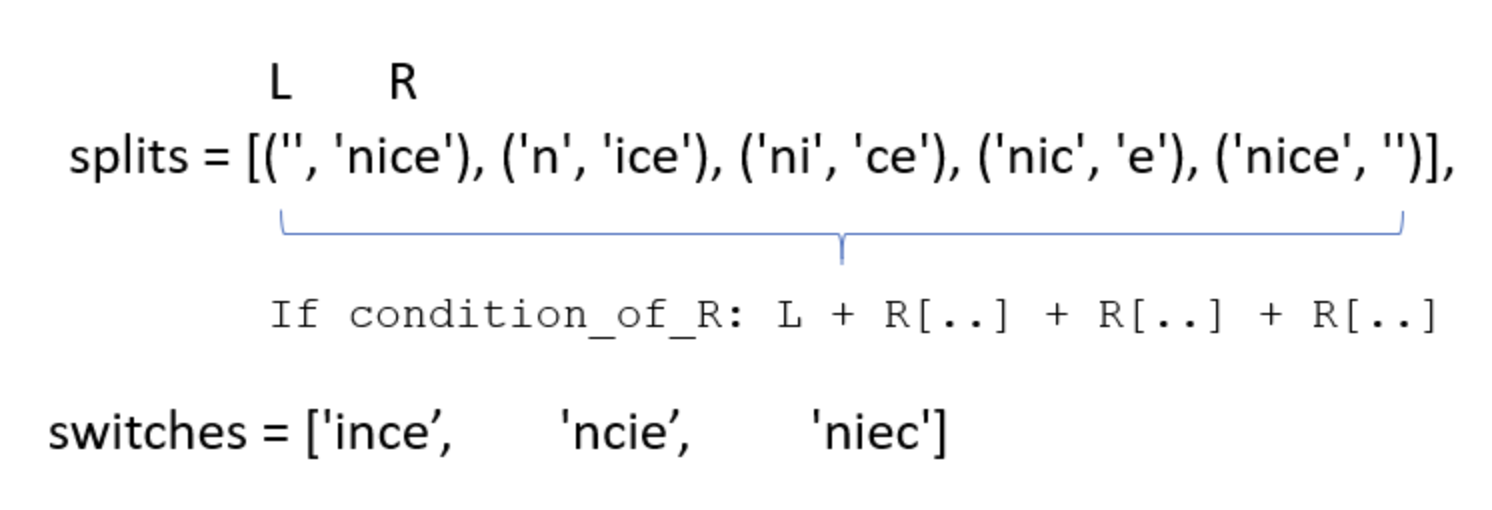

In [ ]:
def delete_letter(word, verbose=False):
    '''
    Input:
        word: the string/word for which you will generate all possible words
                in the vocabulary which have 1 missing character
    Output:
        delete_l: a list of all possible strings obtained by deleting 1 character from word
    '''

    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    delete_l = [word[:i] + word[i + 1:] for i in range(len(word))]

    if verbose: print(f"input word {word}, \nsplit_l = {split_l}, \ndelete_l = {delete_l}")

    return delete_l

In [ ]:
delete_word_l = delete_letter(word="cans",
                        verbose=True)

input word cans, 
split_l = [('', 'cans'), ('c', 'ans'), ('ca', 'ns'), ('can', 's')], 
delete_l = ['ans', 'cns', 'cas', 'can']


**Задание. Реализация switch_letter**

По аналогии, реализуйте функцию switch_letter, которая будет менять две буквы в слове.

Она принимает слово и возвращает список всех возможных перестановок двух букв, находящихся рядом друг с другом.

Например, для слова 'eta' она возвращает \{'eat', 'tea'\}, но не возвращает 'ate'.

**Шаг 1**: такой же, как и в delete_letter().

**Шаг 2**: Генератор списка или цикл for, который формирует строки путем обмена местами соседних букв.

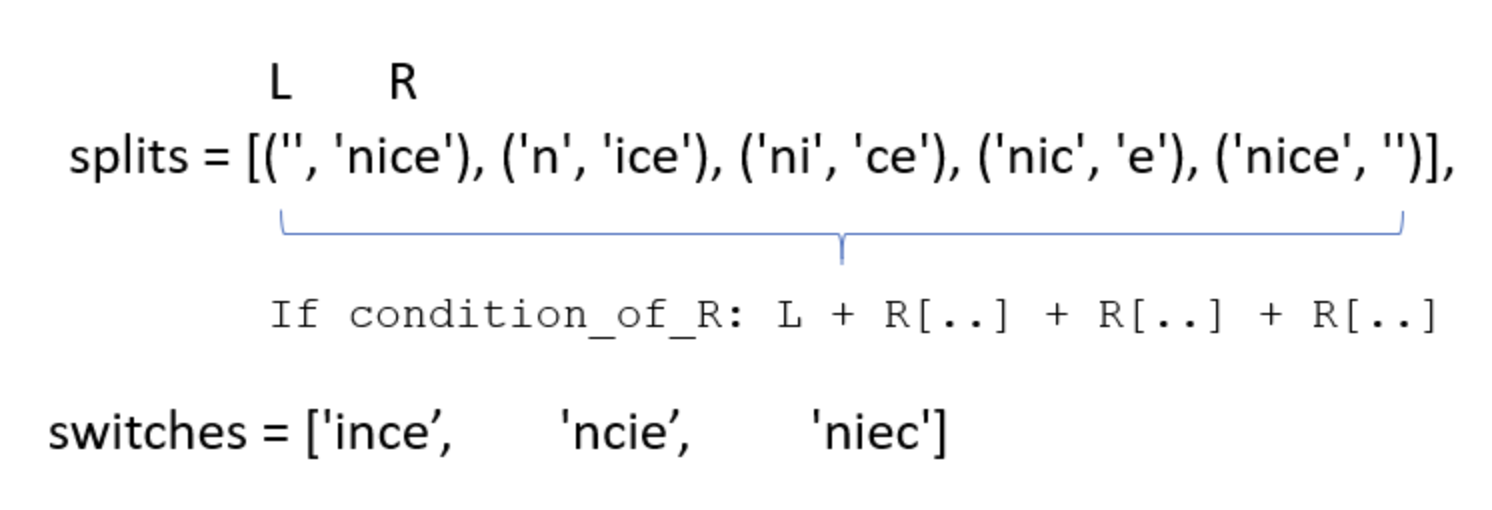

In [ ]:
def switch_letter(word, verbose=False):
    '''
    Input:
        word: input string
     Output:
        switches: a list of all possible strings with one adjacent charater switched
    '''

    switch_l = #YOUR CODE IS HERE
    return switch_l

In [ ]:
# @title Решение

def switch_letter(word, verbose=False):
    '''
    Input:
        word: input string
     Output:
        switches: a list of all possible strings with one adjacent charater switched
    '''

    switch_l = [word[:i] + word[i + 1] + word[i] + word[i + 2:] for i in range(len(word) - 1)]
    split_l = [(word[:i], word[i:]) for i in range(len(word))]

    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nswitch_l = {switch_l}")

    return switch_l

In [ ]:
switch_word_l = switch_letter(word="eta", verbose=True)

Expected output

```Python
Input word = eta
split_l = [('', 'eta'), ('e', 'ta'), ('et', 'a')]
switch_l = ['tea', 'eat']
```

In [ ]:
print(f"Number of outputs of switch_letter('at') is {len(switch_letter('at'))}")

assert(len(switch_letter('at')) == 1)

###Задание. Реализация replace_letter

Теперь реализуйте функцию, которая принимает слово и возвращает список строк с одной замененной буквой из исходного слова.


In [ ]:
def replace_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word
    Output:
        replaces: a list of all possible strings where we replaced one letter from the original word.
    '''

    letters = 'abcdefghijklmnopqrstuvwxyz'
    replace_l = []
    for i in range(len(word)):
        for letter in letters:
            if letter != word[i]:
                replace_l.append(word[:i] + letter + word[i + 1:])
    replace_l.sort()

    split_l = [(word[:i], word[i:]) for i in range(len(word))]

    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nreplace_l {replace_l}")

    return replace_l

In [ ]:
replace_l = replace_letter(word='can', verbose=True)

In [ ]:
print(f"Number of outputs of switch_letter('at') is {len(switch_letter('at'))}")

###Задание. Реализация insert_letter

По аналогии, реализуйте функцию, которая будет добавлять одну букву в слово.

In [ ]:
def insert_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word
    Output:
        inserts: a set of all possible strings with one new letter inserted at every offset
    '''
    letters = 'abcdefghijklmnopqrstuvwxyz'
    split_l = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    insert_l = #YOUR CODE IS HERE

    if verbose: print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")

    return insert_l

In [ ]:
# @title Решение
def insert_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word
    Output:
        inserts: a set of all possible strings with one new letter inserted at every offset
    '''
    letters = 'abcdefghijklmnopqrstuvwxyz'
    split_l = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    insert_l = [a + letter + b for a, b in split_l for letter in letters]

    if verbose: print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")

    return insert_l

In [ ]:
insert_l = insert_letter('at', True)
assert(len(insert_l) == 78)
print(f"Number of strings output by insert_letter('at') is {len(insert_l)}")

Input word at 
split_l = [('', 'at'), ('a', 't'), ('at', '')] 
insert_l = ['aat', 'bat', 'cat', 'dat', 'eat', 'fat', 'gat', 'hat', 'iat', 'jat', 'kat', 'lat', 'mat', 'nat', 'oat', 'pat', 'qat', 'rat', 'sat', 'tat', 'uat', 'vat', 'wat', 'xat', 'yat', 'zat', 'aat', 'abt', 'act', 'adt', 'aet', 'aft', 'agt', 'aht', 'ait', 'ajt', 'akt', 'alt', 'amt', 'ant', 'aot', 'apt', 'aqt', 'art', 'ast', 'att', 'aut', 'avt', 'awt', 'axt', 'ayt', 'azt', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz']
Number of strings output by insert_letter('at') is 78


###Задание. Получение всевозможных слов на расстоянии 1 и 2 от исходного.

Теперь мы можем реализовать функции, которые, получая на вход строку, будут возвращать все возможные строки с одним или двумя изменениями.

Полученные слова можно будет использовать для получения наиболее вероятного слова, которое надо напечатать, aka typing suggestion.

**Задание**. Реализуйте функцию edit_one_letter, которая будет возвращать все возможные слова, которые находятся на расстоянии 1 от исходного. Эти изменения содержат replace, insert, delete и switch операции. switch операция используется как опциональная. Используйте функции, которые написали в предыдущих заданиях.

**Учтите**, что реализованные вами функции возвращали массив. Используйте множества, чтобы получить уникальные элементы.



In [ ]:
def edit_one_letter(word, allow_switches = True):
    """
    Input:
        word: the string/word for which we will generate all possible wordsthat are one edit away.
        allow_switches: use switches or not
    Output:
        edit_one_set: a set of words with one possible edit. Please return a set. and not a list.
    """

    edit_one_set = #YOUR CODE IS HERE

    if allow_switches:
        edit_one_set = #YOUR CODE IS HERE

    return edit_one_set

In [ ]:
# @title Решение
def edit_one_letter(word, allow_switches = True):
    """
    Input:
        word: the string/word for which we will generate all possible wordsthat are one edit away.
        allow_switches: use switches or not
    Output:
        edit_one_set: a set of words with one possible edit. Please return a set. and not a list.
    """

    edit_one_set = set().union(replace_letter(word)).union(insert_letter(word)).union(delete_letter(word))

    if allow_switches:
        edit_one_set = edit_one_set.union(switch_letter(word))

    return edit_one_set

In [ ]:
tmp_word = "at"
tmp_edit_one_set = edit_one_letter(tmp_word)
# turn this into a list to sort it, in order to view it
tmp_edit_one_l = sorted(list(tmp_edit_one_set))

print(f"input word {tmp_word} \nedit_one_l \n{tmp_edit_one_l}\n")
print(f"The type of the returned object should be a set {type(tmp_edit_one_set)}")
assert(len(edit_one_letter('at')) == 129)
print(f"Number of outputs from edit_one_letter('at') is {len(edit_one_letter('at'))}")

input word at 
edit_one_l 
['a', 'aa', 'aat', 'ab', 'abt', 'ac', 'act', 'ad', 'adt', 'ae', 'aet', 'af', 'aft', 'ag', 'agt', 'ah', 'aht', 'ai', 'ait', 'aj', 'ajt', 'ak', 'akt', 'al', 'alt', 'am', 'amt', 'an', 'ant', 'ao', 'aot', 'ap', 'apt', 'aq', 'aqt', 'ar', 'art', 'as', 'ast', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz', 'au', 'aut', 'av', 'avt', 'aw', 'awt', 'ax', 'axt', 'ay', 'ayt', 'az', 'azt', 'bat', 'bt', 'cat', 'ct', 'dat', 'dt', 'eat', 'et', 'fat', 'ft', 'gat', 'gt', 'hat', 'ht', 'iat', 'it', 'jat', 'jt', 'kat', 'kt', 'lat', 'lt', 'mat', 'mt', 'nat', 'nt', 'oat', 'ot', 'pat', 'pt', 'qat', 'qt', 'rat', 'rt', 'sat', 'st', 't', 'ta', 'tat', 'tt', 'uat', 'ut', 'vat', 'vt', 'wat', 'wt', 'xat', 'xt', 'yat', 'yt', 'zat', 'zt']

The type of the returned object should be a set <class 'set'>
Number of outputs from edit_one_letter('at') is 129


Теперь обобщите реализованную вами edit_one_letter до поиска слов на расстоянии 2х изменений.

**Hint**. Возьмите слова, полученные с помощью edit_one_letter (они находятся на расстоянии 1 от исходного слова), и примените к ним    функцию edit_one_letter. Полученные слова будут находиться на расстоянии 2 от исходного.


**Задание**: Реализуйте функцию  edit_two_letters, которая для слова $w$ будет возвращать множество слов, находящихся на расстоянии 2 от него.

In [ ]:
def edit_two_letters(word, allow_switches = True):
    '''
    Input:
        word: the input string/word
    Output:
        edit_two_set: a set of strings with all possible two edits
    '''
    edit_two_set = set()
    #YOUR CODE IS HERE
    return edit_two_set

In [ ]:
# @title Решение
def edit_two_letters(word, allow_switches = True):
    '''
    Input:
        word: the input string/word
    Output:
        edit_two_set: a set of strings with all possible two edits
    '''
    edit_one_set = edit_one_letter(word, allow_switches)
    edit_two_set = set()

    for entry in edit_one_set:
        edit_two_set = edit_two_set.union(edit_one_letter(entry, allow_switches))

    return edit_two_set

In [ ]:
tmp_edit_two_set = edit_two_letters("a")
tmp_edit_two_l = sorted(list(tmp_edit_two_set))
print(f"Number of strings with edit distance of two: {len(tmp_edit_two_l)}")
print(f"First 10 strings {tmp_edit_two_l[:10]}")
print(f"Last 10 strings {tmp_edit_two_l[-10:]}")
print(f"The data type of the returned object should be a set {type(tmp_edit_two_set)}")
print(f"Number of strings that are 2 edit distances from 'at' is {len(edit_two_letters('at'))}")

Number of strings with edit distance of two: 2654
First 10 strings ['', 'a', 'aa', 'aaa', 'aab', 'aac', 'aad', 'aae', 'aaf', 'aag']
Last 10 strings ['zv', 'zva', 'zw', 'zwa', 'zx', 'zxa', 'zy', 'zya', 'zz', 'zza']
The data type of the returned object should be a set <class 'set'>
Number of strings that are 2 edit distances from 'at' is 7154


###Задание 3. Предлагаем изменения слова

**Задание**. Реализуйте `get_corrections`, который вернет массив наиболее возможных замен слова. Массив должен содержать от 0 до $n$ кортежей вида (слово: его_вероятность).


**Шаг 1:** Сгенерируйте исправления для предложенного слова: используйте для этого функции, которые вы разработали выше.

 Алгоритм должен следовать следующей логике:

* Если слово есть в вокабуляре (корпусе всех слов из текста), то надо вернуть его.
* Иначе, если есть предложения из `edit_one_letter`, которые есть в вокабуляре, используйте их.
* Иначе, если есть предложния из `edit_two_letters`, которые есть в вокабуляре, используйте их.
* Иначе, предложите введенное слово.  
* Идея заключается в том, что чем на меньшем расстоянии сгенерированное слово находится от исходного, тем более оно вероятно.

**Шаг 2**: Cоздайте 'best_words' словарь, где ключ -- это предложенное исправленное слово, а значение -- вероятность этого слова. Если слово не в вокабуляре, его вероятность равна 0.

**Шаг 3**: Выберите $n$ лучших предложений. Их может быть меньше, чем $n$.

In [ ]:
def get_corrections(word, probs, vocab, n=2, verbose = False):
    '''
    Input:
        word: a user entered string to check for suggestions
        probs: a dictionary that maps each word to its probability in the corpus
        vocab: a set containing all the vocabulary
        n: number of possible word corrections you want returned in the dictionary
    Output:
        n_best: a list of tuples with the most probable n corrected words and their probabilities.
    '''

    suggestions = #YOUR CODE
    n_best = #YOUR CODE

    if verbose: print("entered word = ", word, "\nsuggestions = ", suggestions)

    return n_best

In [ ]:
# @title Решение
def get_corrections(word, probs, vocab, n=2, verbose = False):
    '''
    Input:
        word: a user entered string to check for suggestions
        probs: a dictionary that maps each word to its probability in the corpus
        vocab: a set containing all the vocabulary
        n: number of possible word corrections you want returned in the dictionary
    Output:
        n_best: a list of tuples with the most probable n corrected words and their probabilities.
    '''

    suggestions = list((word in vocab and word) or edit_one_letter(word).intersection(vocab) or edit_two_letters(word).intersection(vocab))
    n_best = [(s, probs[s]) for s in suggestions]

    if verbose: print("entered word = ", word, "\nsuggestions = ", suggestions)

    return n_best

In [ ]:
# Test your implementation - feel free to try other words in my word
my_word = 'dys'
tmp_corrections = get_corrections(my_word, probs, vocab, 2, verbose=True) # keep verbose=True
for i, word_prob in enumerate(tmp_corrections):
    print(f"word {i}: {word_prob[0]}, probability {word_prob[1]:.6f}")

print(f"data type of corrections {type(tmp_corrections)}")

entered word =  dys 
suggestions =  ['days', 'dye']
word 0: days, probability 0.000410
word 1: dye, probability 0.000019
data type of corrections <class 'list'>


##Оценка автокорректора. Minimum Edit distance

Мы реализовали наш автокорректор! Как теперь можно измерить похожесть двух полученных строк? Например, "waht" и "what".

Также, как можно эффективно найти самый короткий путь получить из слова "waht" слово "what"?

Далее мы реализуем систему с использованием динамического программирования, которая будет находить наименьшее количество изменений, необходимое для преобразования строки $w_1$ в строку $w_2$.

TODO: доделать эту часть

# Современные нейросетевые методы

#Языковые модели

Часть про современные методы отсюда: https://github.com/agcr/vk-ir-course-fall-2024/tree/main/seminars/04-spell-checking